In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_multitaper
from scipy import stats
import pandas as pd
import matplotlib.patches as mpatches
from pathlib import Path

In [2]:
# 설정 부분
base_dir = os.path.join(os.getcwd(), "EEG_arithmetic_task")  # 데이터가 저장된 디렉토리 경로 설정
subjects = [f"Subject{i:02d}" for i in range(36)]  # Subject00부터 Subject35까지
conditions = ["1", "2"]  # 01: 휴식상태, 02: Mental arithmetic task
channels_of_interest = ["EEG P3", "EEG P4", "EEG Pz", "EEG Fz"]  # 관심 채널
frequency_bands = {
    "theta": (4, 8),
    "alpha": (8, 13)
}


# 결과 저장용 데이터프레임 초기화
results = []

# 진행 상황 추적
total_files = len(subjects) * len(conditions)
processed_files = 0

In [3]:
# 각 피험자별로 처리
for subject in subjects:
    # 피험자별 결과 저장
    subject_data = {}
    
    for condition in conditions:
        filename = f"{subject}_{condition}.edf"  # 파일 이름 형식에 맞게 조정
        file_path = os.path.join(base_dir, filename)
        
        # 파일 존재 여부 확인
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없음: {file_path}")
            continue
        
        try:
            # EEG 데이터 로드
            raw = mne.io.read_raw_edf(file_path, preload=True)
            
            # 60Hz 노치 필터 적용 (전원 노이즈 제거)
            raw.notch_filter(freqs=60)
            
            # 1-45Hz 대역 필터 적용
            raw.filter(l_freq=1, h_freq=45)
            
            # 관심 채널만 선택
            raw.pick_channels(channels_of_interest)
            
            # 채널별 PSD (Power Spectral Density) 계산
            fmin, fmax = 2, 40  # 주파수 범위
            psd = raw.compute_psd(fmin=fmin, fmax=fmax, n_fft=512, n_overlap=256)
            psds = psd.get_data()
            freqs = psd.freqs
            
            # 조건별로 데이터 저장
            subject_data[condition] = {
                'raw': raw,
                'psds': psds,
                'freqs': freqs
            }
            
            # 진행 상황 업데이트
            processed_files += 1
            print(f"처리 중: {processed_files}/{total_files} - {subject}_{condition}")
            
        except Exception as e:
            print(f"파일 처리 중 오류 발생: {file_path}")
            print(f"오류 메시지: {str(e)}")
    
    # 조건 01과 02가 모두 있는 경우에만 ERD/ERS 계산
    if '1' in subject_data and '2' in subject_data:
        # 각 채널 및 주파수 대역에 대해 ERD/ERS 계산
        for ch_idx, channel in enumerate(channels_of_interest):
            for band_name, (band_min, band_max) in frequency_bands.items():
                # 해당 주파수 대역의 인덱스 찾기
                freq_idx = np.logical_and(
                    subject_data['1']['freqs'] >= band_min,
                    subject_data['1']['freqs'] <= band_max
                )
                
                # 각 조건에서 평균 파워 계산
                power_rest = np.mean(subject_data['1']['psds'][ch_idx, freq_idx])
                power_task = np.mean(subject_data['2']['psds'][ch_idx, freq_idx])
                
                # ERD/ERS 계산 (휴식 상태 대비 변화율, %)
                # ERD는 음수, ERS는 양수로 표현됨
                erd_ers = ((power_rest - power_task) / power_rest) * 100
                
                # 결과 저장
                results.append({
                    'subject': subject,
                    'channel': channel,
                    'band': band_name,
                    'power_rest': power_rest,
                    'power_task': power_task,
                    'erd_ers': erd_ers
                })
    else:
        print(f"{subject}: 휴식 또는 작업 상태 데이터가 누락되었습니다.")

Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 2/72 - Subject00_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 8/72 - Subject03_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
----

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 10/72 - Subject04_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 12/72 - Subject05_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 16/72 - Subject07_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject08_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 18/72 - Subject08_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 22/72 - Subject10_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject11_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 24/72 - Subject11_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject12_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 26/72 - Subject12_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 32/72 - Subject15_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject16_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 34/72 - Subject16_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject17_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 36/72 - Subject17_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject18_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 44/72 - Subject21_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject22_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 46/72 - Subject22_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 48/72 - Subject23_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject24_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 50/72 - Subject24_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject25_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 52/72 - Subject25_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 1.024 (s)
처리 중: 54/72 - Subject26_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject27_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 62/72 - Subject30_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 ...    79.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 65/72 - Subject32_1
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject32_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguou

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


처리 중: 66/72 - Subject32_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 68/72 - Subject33_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject34_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.024 (s)
처리 중: 70/72 - Subject34_2
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [4]:
# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results)

# subject-info.csv 읽어서 Count quality 정보 병합
subject_info = pd.read_csv(os.path.join(base_dir, "subject-info.csv"))
subject_info = subject_info[["Subject", "Count quality"]]
df_results = df_results.merge(subject_info, left_on="subject", right_on="Subject", how="left")
df_results = df_results.drop(columns=["Subject"])  # 중복 컬럼 제거

# 결과 저장
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
df_results.to_csv(os.path.join(results_dir, "erd_ers_results.csv"), index=False)

In [5]:
# 시각화
def plot_erd_ers_by_band_and_channel():
    """주파수 대역과 채널별 ERD/ERS 결과 시각화"""
    plt.figure(figsize=(14, 10))
    
    for band_idx, band in enumerate(frequency_bands.keys()):
        plt.subplot(len(frequency_bands), 1, band_idx + 1)
        
        # 채널별 결과 추출
        band_data = df_results[df_results['band'] == band]
        
        # 채널별 평균 ERD/ERS 계산
        channel_means = band_data.groupby('channel')['erd_ers'].mean()
        channel_sems = band_data.groupby('channel')['erd_ers'].sem()
        


        # 색상 지정: ERD(음수)는 빨간색, ERS(양수)는 파란색
        colors = ['red' if val < 0 else 'blue' for val in channel_means.values]

        
        # 바 그래프 그리기
        bars = plt.bar(channel_means.index, channel_means.values, color=colors)
        
        # 오차 막대 추가
        for i, (_, sem) in enumerate(channel_sems.items()):
            plt.errorbar(i, channel_means.iloc[i], yerr=sem, fmt='none', color='black', capsize=5)
        
        # 축 설정
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        plt.title(f'{band.capitalize()} band ERD/ERS', fontsize=14)
        plt.ylabel('ERD/ERS (%)')
        plt.ylim(-50, 50)  # 적절하게 조정

        # 범례 추가
        erd_patch = mpatches.Patch(color='red', label='ERS')
        ers_patch = mpatches.Patch(color='blue', label='ERD')
        plt.legend(handles=[erd_patch, ers_patch], loc='upper right')
        
        # 각 채널에 대한 paired t-test 수행
        for i, channel in enumerate(channels_of_interest):
            ch_data = band_data[band_data['channel'] == channel]
            t_stat, p_val = stats.ttest_1samp(ch_data['erd_ers'].values, 0)
            
            # p-value 표시
            significance = ""
            if p_val < 0.001:
                significance = "***"
            elif p_val < 0.01:
                significance = "**"
            elif p_val < 0.05:
                significance = "*"
                
            if significance:
                plt.text(i, channel_means.iloc[i] + (5 if channel_means.iloc[i] >= 0 else -10), 
                         significance, ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "erd_ers_by_band_and_channel.png"))
    plt.close()

In [6]:
def plot_erd_ers_by_band_and_channel_grouped():
    """Count quality 그룹별로 ERD/ERS 시각화"""
    for group in [0, 1]:
        group_data = df_results[df_results["Count quality"] == group]
        if group_data.empty:
            continue
        plt.figure(figsize=(14, 10))
        for band_idx, band in enumerate(frequency_bands.keys()):
            plt.subplot(len(frequency_bands), 1, band_idx + 1)
            band_data = group_data[group_data['band'] == band]
            channel_means = band_data.groupby('channel')['erd_ers'].mean()
            channel_sems = band_data.groupby('channel')['erd_ers'].sem()
            colors = ['red' if val < 0 else 'blue' for val in channel_means.values]
            bars = plt.bar(channel_means.index, channel_means.values, color=colors)
            for i, (_, sem) in enumerate(channel_sems.items()):
                plt.errorbar(i, channel_means.iloc[i], yerr=sem, fmt='none', color='black', capsize=5)
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            plt.title(f'{band.capitalize()} band ERD/ERS (Count quality={group})', fontsize=14)
            plt.ylabel('ERD/ERS (%)')
            plt.ylim(-50, 50)
            erd_patch = mpatches.Patch(color='red', label='ERS')
            ers_patch = mpatches.Patch(color='blue', label='ERD')
            plt.legend(handles=[erd_patch, ers_patch], loc='upper right')
            for i, channel in enumerate(channels_of_interest):
                ch_data = band_data[band_data['channel'] == channel]
                t_stat, p_val = stats.ttest_1samp(ch_data['erd_ers'].values, 0)
                significance = ""
                if p_val < 0.001:
                    significance = "***"
                elif p_val < 0.01:
                    significance = "**"
                elif p_val < 0.05:
                    significance = "*"
                if significance:
                    plt.text(i, channel_means.iloc[i] + (5 if channel_means.iloc[i] >= 0 else -10), significance, ha='center')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"erd_ers_by_band_and_channel_group{group}.png"))
        plt.close()

In [7]:
import numpy as np

def plot_erd_ers_by_band_and_channel_group_compare():
    """Count quality 그룹별 ERD/ERS를 한 그래프에서 비교 시각화"""
    group_labels = [0, 1]
    group_colors = ['#66CDAA', '#FFB90F'] 
    group_names = ['Count quality=0', 'Count quality=1']

    plt.figure(figsize=(14, 10))
    bar_width = 0.35
    x = np.arange(len(channels_of_interest))

    for band_idx, band in enumerate(frequency_bands.keys()):
        plt.subplot(len(frequency_bands), 1, band_idx + 1)
        means = []
        sems = []
        for group in group_labels:
            group_data = df_results[(df_results["Count quality"] == group) & (df_results['band'] == band)]
            channel_means = group_data.groupby('channel')['erd_ers'].mean().reindex(channels_of_interest)
            channel_sems = group_data.groupby('channel')['erd_ers'].sem().reindex(channels_of_interest)
            means.append(channel_means)
            sems.append(channel_sems)
        # 막대 위치 조정
        plt.bar(x - bar_width/2, means[0], bar_width, yerr=sems[0], color=group_colors[0], label=group_names[0], capsize=5)
        plt.bar(x + bar_width/2, means[1], bar_width, yerr=sems[1], color=group_colors[1], label=group_names[1], capsize=5)
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        plt.title(f'{band.capitalize()} band ERD/ERS', fontsize=14)
        plt.ylabel('ERD/ERS (%)')
        plt.xticks(x, channels_of_interest)
        plt.ylim(-50, 50)
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "erd_ers_by_band_and_channel_group_compare.png"))
    plt.show()

In [8]:
def plot_topographic_maps():
    """채널별 ERD/ERS 결과의 머리 지도"""
    for band in frequency_bands.keys():
        # 새로운 figure 생성
        fig = plt.figure(figsize=(10, 6))
        
        # 데이터 준비
        band_data = df_results[df_results['band'] == band]
        
        # 각 조건에 대한 서브플롯
        plt.suptitle(f'{band.capitalize()} 대역의 ERD/ERS 토포그래픽 맵', fontsize=16)
        
        # 채널별 평균 ERD/ERS 값
        erd_ers_values = []
        for channel in channels_of_interest:
            ch_data = band_data[band_data['channel'] == channel]
            erd_ers_values.append(ch_data['erd_ers'].mean())
        
        # 채널 위치 정보 생성
        ch_pos = {
            'EEG P3': (-0.5, -0.5),  # 왼쪽 후두부
            'EEG P4': (0.5, -0.5),   # 오른쪽 후두부
            'EEG Pz': (0, -0.5),     # 중앙 후두부
            'EEG Fz': (0, 0.5)       # 중앙 전두부
        }
        
        # 토포맵 생성
        try:
            # ERD/ERS 값을 채널 위치에 매핑
            mne.viz.plot_topomap(erd_ers_values, ch_pos, 
                                names=channels_of_interest,
                                cmap='RdBu_r', 
                                vlim=(-30, 30))  # vmin, vmax 대신 vlim 사용
            plt.colorbar(label='ERD/ERS (%)')
            
            # 저장
            plt.savefig(os.path.join(results_dir, f"topo_{band}.png"))
            # 그래프 표시
            plt.draw()
            plt.pause(0.1)  # 잠시 대기하여 그래프가 표시되도록 함
            
        except Exception as e:
            print(f"토포맵 생성 중 오류 발생: {str(e)}")
        
        plt.close(fig)

In [9]:
def plot_time_frequency_maps():
    """시간-주파수 분석 맵 생성 (하나의 대표 피험자 사용)"""
    # 대표 피험자 선택 (첫 번째로 완전한 데이터를 가진 피험자)
    representative_subject = None
    for subject in subjects:
        if subject in set(df_results['subject']):
            representative_subject = subject
            break
    
    if representative_subject is None:
        print("시간-주파수 맵을 생성할 유효한 피험자를 찾을 수 없습니다.")
        return
    
    print(f"시간-주파수 맵 생성에 사용할 대표 피험자: {representative_subject}")
    
    # 해당 피험자의 데이터 파일 다시 로드
    for condition_name, condition in zip(['휴식', '인지작업'], conditions):
        filename = f"{representative_subject}_{condition}.edf"
        file_path = os.path.join(base_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없음: {file_path}")
            continue
        
        try:
            # 데이터 로드
            raw = mne.io.read_raw_edf(file_path, preload=True)
            raw.filter(l_freq=1, h_freq=45)
            
            # 관심 채널만 선택
            raw.pick_channels(channels_of_interest)
            
            # 시간-주파수 분석 (멀티테이퍼 방법)
            freqs = np.arange(4, 20, 1)  # theta와 alpha 대역을 포함하는 주파수
            n_cycles = freqs / 2.  # 낮은 주파수에는 더 적은 사이클 사용
            
            # 에포크로 변환 (연속 데이터를 10초 단위로 분할)
            duration = 10.0  # 초 단위
            events = mne.make_fixed_length_events(raw, duration=duration)
            epochs = mne.Epochs(raw, events, tmin=0, tmax=duration, baseline=None, preload=True)
            
            # 시간-주파수 분석
            power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, 
                                  time_bandwidth=4.0, return_itc=False, average=True)
            
            # 각 채널별로 플롯
            fig = power.plot_joint(baseline=None, mode='mean', 
                                 timefreqs=[(5, 6), (10, 10)],  # (time, frequency) 쌍
                                 title=f'{representative_subject} - {condition_name} 상태의 시간-주파수 지도')
            
            # 저장
            plt.savefig(os.path.join(results_dir, f"tf_{representative_subject}_{condition}.png"))
            # 그래프 표시
            plt.show()
            
        except Exception as e:
            print(f"시간-주파수 맵 생성 중 오류 발생: {str(e)}")

In [10]:
# 통계 분석: 각 주파수 대역과 채널에 대한 그룹 수준의 t-검정
def run_statistical_analysis():
    """각 주파수 대역과 채널에 대한 통계 분석 수행"""
    stats_results = []
    
    for band in frequency_bands.keys():
        for channel in channels_of_interest:
            # 해당 대역 및 채널에 대한 데이터 추출
            data = df_results[(df_results['band'] == band) & 
                             (df_results['channel'] == channel)]
            
            # t-검정 수행 (ERD/ERS가 0과 유의하게 다른지)
            t_stat, p_val = stats.ttest_1samp(data['erd_ers'].values, 0)
            
            # 효과 크기 계산 (Cohen's d)
            effect_size = np.mean(data['erd_ers']) / np.std(data['erd_ers'])
            
            # 결과 저장
            stats_results.append({
                'band': band,
                'channel': channel,
                'mean_erd_ers': data['erd_ers'].mean(),
                'std_erd_ers': data['erd_ers'].std(),
                't_statistic': t_stat,
                'p_value': p_val,
                'effect_size': effect_size,
                'significant': p_val < 0.05
            })
    
    # 결과를 데이터프레임으로 변환
    df_stats = pd.DataFrame(stats_results)
    
    # 결과 저장
    df_stats.to_csv(os.path.join(results_dir, "statistical_results.csv"), index=False)
    
    # 결과 출력
    print("\n통계 분석 결과:")
    print(df_stats[['band', 'channel', 'mean_erd_ers', 'p_value', 'significant']])
    
    return df_stats

ERD/ERS 분석 시작...

기본 분석 완료. 시각화 및 통계 분석 시작...


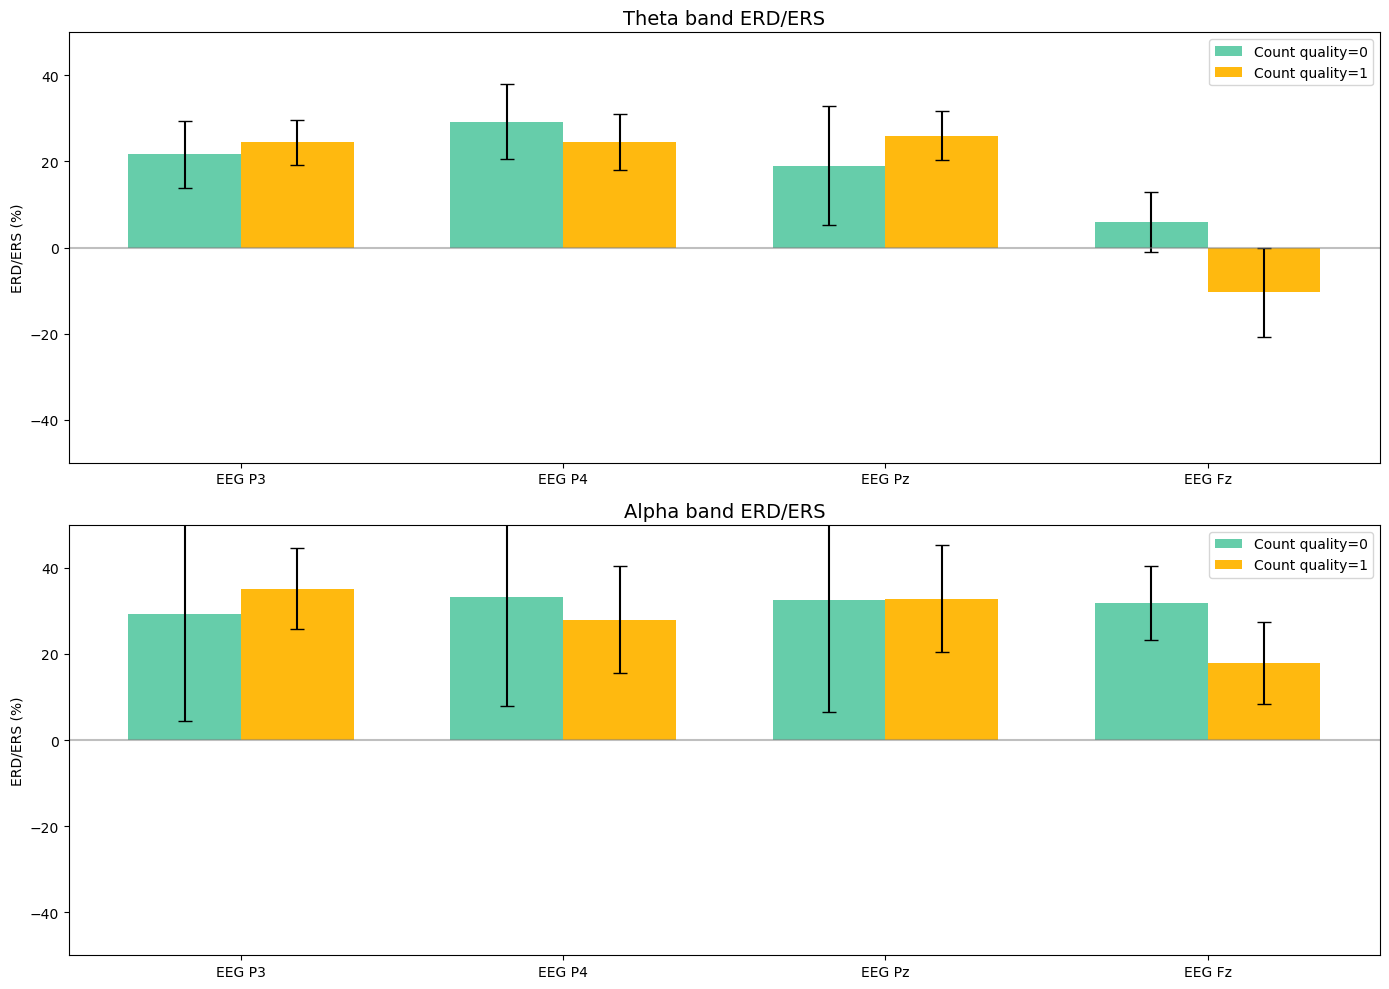

토포맵 생성 중 오류 발생: 'dict' object has no attribute 'ndim'
토포맵 생성 중 오류 발생: 'dict' object has no attribute 'ndim'
시간-주파수 맵 생성에 사용할 대표 피험자: Subject00
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)

NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


시간-주파수 맵 생성 중 오류 발생: No digitization points found.
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_arithmetic_task\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
6 matching events foun

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


시간-주파수 맵 생성 중 오류 발생: No digitization points found.

통계 분석 결과:
    band channel  mean_erd_ers   p_value  significant
0  theta  EEG P3     23.648939  0.000004         True
1  theta  EEG P4     25.855940  0.000018         True
2  theta  EEG Pz     24.064791  0.000120         True
3  theta  EEG Fz     -5.832178  0.459182        False
4  alpha  EEG P3     33.570494  0.001214         True
5  alpha  EEG P4     29.417695  0.012682         True
6  alpha  EEG Pz     32.702919  0.006524         True
7  alpha  EEG Fz     21.760905  0.004813         True

분석이 완료되었습니다. 결과는 'results' 폴더에 저장되었습니다.


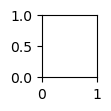

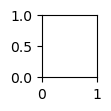

In [11]:
# 모든 분석 및 시각화 실행
if __name__ == "__main__":
    print("ERD/ERS 분석 시작...")
    
    if len(results) > 0:
        print("\n기본 분석 완료. 시각화 및 통계 분석 시작...")
        
        # 그래프 생성
        plot_erd_ers_by_band_and_channel()
        plot_erd_ers_by_band_and_channel_grouped()
        plot_erd_ers_by_band_and_channel_group_compare()
        plot_topographic_maps()
        plot_time_frequency_maps()
        
        # 통계 분석
        stats_df = run_statistical_analysis()
        
        print("\n분석이 완료되었습니다. 결과는 'results' 폴더에 저장되었습니다.")
    else:
        print("분석할 데이터가 없습니다. 데이터 경로와 파일 형식을 확인하세요.")